Suggested Bin width: 0.004992338504388339
Suggested Number of bins: 17
Optimal Weibull parameters: shape (c) = 3.125, scale = 0.028, R² = 0.670


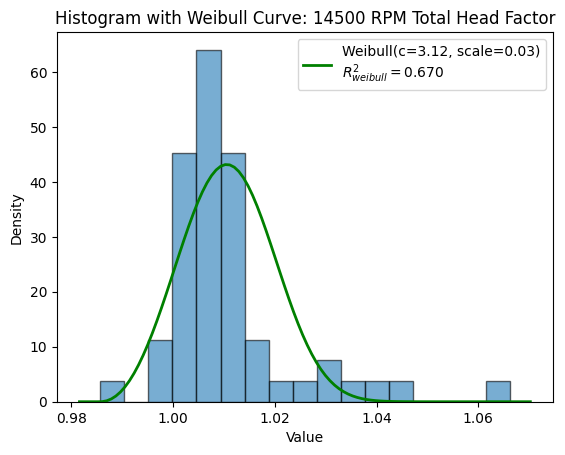

Arithmetic Mean = 1.011

Expected value (Weibull): 1.0108
Median Weibull: 1.0107
Standard Error of Mean: ±0.0032 or ±0.31% of the Expected Value
Standard Deviation : 0.0012
Standard Error of Mean Margin: 0.62% of the Expected Value
Number of samples = 56, which is 6.4% of Total Data


In [179]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import weibull_min, t
import scipy.special as sps  # for the gamma function
import math

# 14500 RPM Head
# Sample data - replace this list with your actual data
# remove outlier ,1.0662,1.0469
data = [1.0152,0.9952,1.0002,1.0662,1.0094,1.0084,1.0018,1.0101,1.0142,1.0130,0.9993,1.0031,1.0090,1.0046,1.0086,1.0129,1.0078,1.0034,1.0283,1.0114,1.0469,1.0029,1.0201,1.0135,0.9999,1.0033,1.0082,0.9856,0.9995,1.0011,1.0074,1.0121,1.0101,1.0136,1.0070,1.0019,1.0098,1.0128,1.0122,1.0047,1.0003,1.0315,1.0086,1.0014,1.0059,1.0263,1.0416,1.0073,1.0035,1.0060,1.0340,1.0047,1.0147,1.0090,1.0091,1.0087]


# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.01
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14500 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull


# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.003541685169343591
Suggested Number of bins: 10
Optimal Weibull parameters: shape (c) = 2.485, scale = 0.013, R² = 0.938


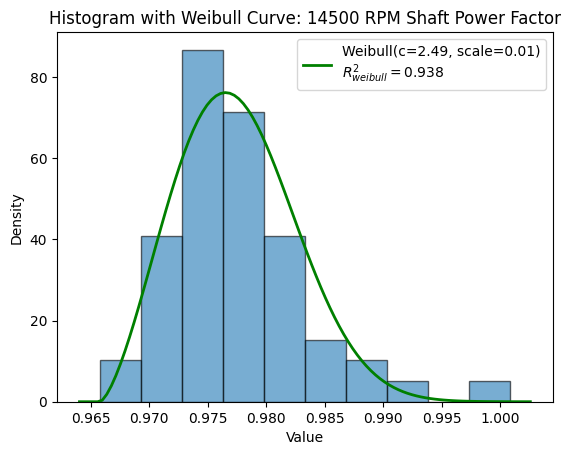

Arithmetic Mean = 0.978

Expected value (Weibull): 0.9775
Median Weibull: 0.9772
Standard Error of Mean: ±0.0018 or ±0.18% of the Expected Value
Standard Deviation : 0.0007
Standard Error of Mean Margin: 0.37% of the Expected Value
Number of samples = 56, which is 6.4% of Total Data


In [180]:
# 14500 RPM Power
# Sample data - replace this list with your actual data
data = [0.9803,0.9742,0.9760,1.0008,0.9745,0.9726,0.9717,0.9771,0.9782,0.9805,0.9705,0.9715,0.9776,0.9735,0.9782,0.9814,0.9757,0.9725,0.9849,0.9781,0.9901,0.9761,0.9824,0.9813,0.9696,0.9759,0.9793,0.9658,0.9728,0.9683,0.9747,0.9756,0.9750,0.9817,0.9732,0.9741,0.9776,0.9789,0.9768,0.9734,0.9725,0.9865,0.9793,0.9714,0.9765,0.9815,0.9912,0.9765,0.9736,0.9740,0.9873,0.9783,0.9848,0.9781,0.9809,0.9755]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.001
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14500 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.006482198686326505
Suggested Number of bins: 13
Optimal Weibull parameters: shape (c) = 1.627, scale = 0.019, R² = 0.937


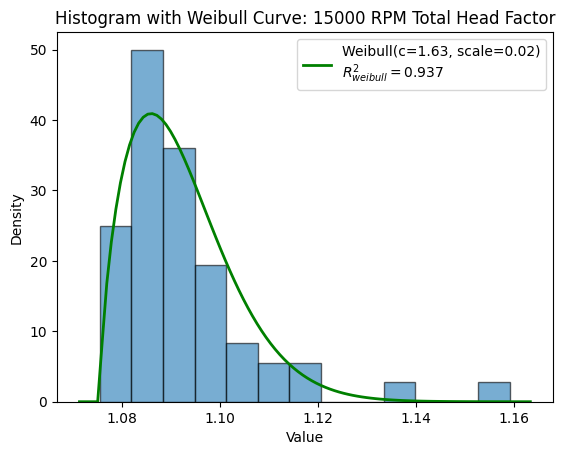

Arithmetic Mean = 1.092

Expected value (Weibull): 1.0924
Median Weibull: 1.0906
Standard Error of Mean: ±0.0038 or ±0.34% of the Expected Value
Standard Deviation : 0.0014
Standard Error of Mean Margin: 0.69% of the Expected Value
Number of samples = 56, which is 6.4% of Total Data


In [181]:
# 15000 RPM Head
# Sample data - replace this list with your actual data
data = [1.0823,1.0889,1.1112,1.1592,1.0790,1.0963,1.0902,1.1127,1.0931,1.0859,1.0914,1.0994,1.1166,1.0910,1.0878,1.0847,1.0831,1.1357,1.0836,1.0833,1.1024,1.1070,1.1150,1.0900,1.0903,1.0902,1.0783,1.0927,1.1061,1.0809,1.0869,1.0756,1.0976,1.0867,1.0893,1.0790,1.0808,1.0905,1.0988,1.0800,1.0836,1.0959,1.0910,1.0794,1.0956,1.0866,1.0852,1.0878,1.0830,1.0866,1.0985,1.0789,1.0849,1.0874,1.0886,1.0860]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15000 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")


Suggested Bin width: 0.0028228929763034144
Suggested Number of bins: 13
Optimal Weibull parameters: shape (c) = 2.857, scale = 0.013, R² = 0.924


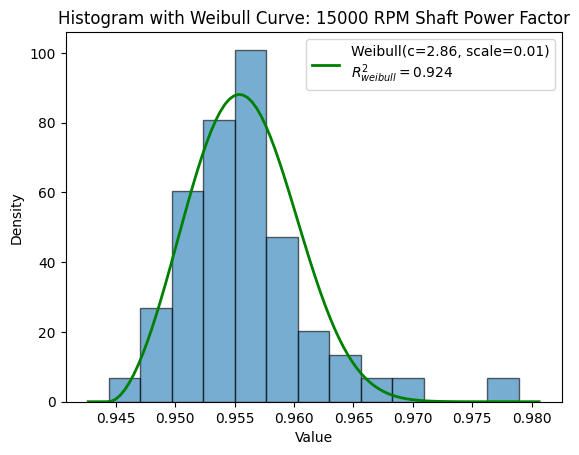

Arithmetic Mean = 0.956

Expected value (Weibull): 0.9558
Median Weibull: 0.9557
Standard Error of Mean: ±0.0015 or ±0.16% of the Expected Value
Standard Deviation : 0.0006
Standard Error of Mean Margin: 0.32% of the Expected Value
Number of samples = 56, which is 6.4% of Total Data


In [182]:
# 15000 RPM Power
# Sample data - replace this list with your actual data
data = [0.9500,0.9570,0.9587,0.9789,0.9444,0.9551,0.9586,0.9591,0.9565,0.9520,0.9562,0.9558,0.9619,0.9492,0.9555,0.9550,0.9473,0.9648,0.9537,0.9537,0.9577,0.9641,0.9683,0.9526,0.9523,0.9508,0.9494,0.9535,0.9664,0.9478,0.9513,0.9519,0.9590,0.9560,0.9559,0.9509,0.9554,0.9568,0.9593,0.9516,0.9527,0.9592,0.9560,0.9531,0.9616,0.9561,0.9527,0.9546,0.9548,0.9564,0.9625,0.9538,0.9566,0.9544,0.9506,0.9553]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15000 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")


Suggested Bin width: 0.008465809600418515
Suggested Number of bins: 13
Optimal Weibull parameters: shape (c) = 1.952, scale = 0.032, R² = 0.834


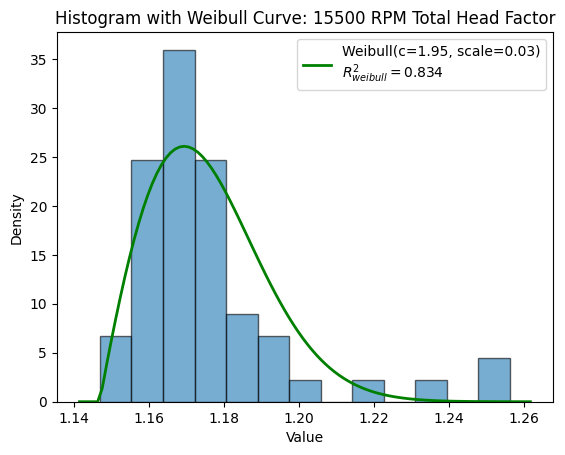

Arithmetic Mean = 1.176

Expected value (Weibull): 1.1757
Median Weibull: 1.1738
Standard Error of Mean: ±0.0056 or ±0.48% of the Expected Value
Standard Deviation : 0.0021
Standard Error of Mean Margin: 0.96% of the Expected Value
Number of samples = 53, which is 6.0% of Total Data


In [183]:
# 15500 RPM Head
# Sample data - replace this list with your actual data
data = [1.1800,1.2562,1.1894,1.1582,1.1633,1.2504,1.1723,1.2180,1.1820,1.1534,1.1606,1.1649,1.1608,1.1576,1.1971,1.1704,1.1652,1.1737,1.2356,1.1814,1.1794,1.1631,1.1828,1.1680,1.1470,1.1645,1.1949,1.1570,1.1845,1.1687,1.1764,1.1539,1.2027,1.1690,1.1679,1.1677,1.1703,1.1783,1.1664,1.1580,1.1699,1.1670,1.1630,1.1709,1.1608,1.1727,1.1677,1.1635,1.1765,1.1765,1.1727,1.1761,1.1646]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15500 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.0031946451322333994
Suggested Number of bins: 13
Optimal Weibull parameters: shape (c) = 1.910, scale = 0.012, R² = 0.701


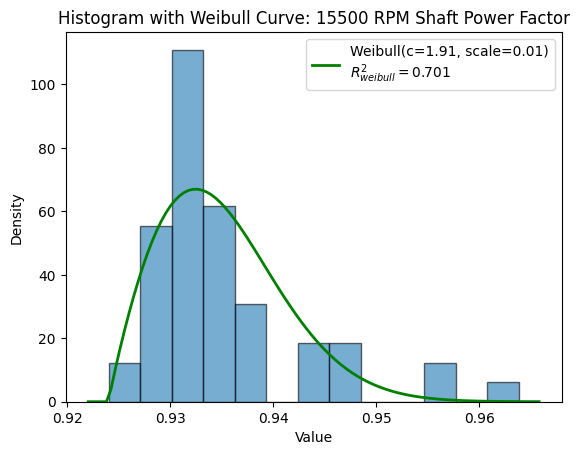

Arithmetic Mean = 0.935

Expected value (Weibull): 0.9350
Median Weibull: 0.9343
Standard Error of Mean: ±0.0022 or ±0.24% of the Expected Value
Standard Deviation : 0.0008
Standard Error of Mean Margin: 0.47% of the Expected Value
Number of samples = 53, which is 6.0% of Total Data


In [184]:
# 15500 RPM Power
# Sample data - replace this list with your actual data
data = [0.9311,0.9638,0.9428,0.9272,0.9331,0.9548,0.9328,0.9561,0.9354,0.9276,0.9342,0.9329,0.9240,0.9305,0.9460,0.9323,0.9270,0.9379,0.9459,0.9301,0.9384,0.9344,0.9305,0.9349,0.9271,0.9335,0.9462,0.9295,0.9431,0.9365,0.9305,0.9321,0.9444,0.9304,0.9315,0.9380,0.9351,0.9347,0.9353,0.9299,0.9384,0.9344,0.9320,0.9329,0.9280,0.9319,0.9319,0.9316,0.9351,0.9330,0.9282,0.9271,0.9308]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.01
c_high = 2
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15500 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.008135098176116927
Suggested Number of bins: 16
Optimal Weibull parameters: shape (c) = 1.734, scale = 0.023, R² = 0.937


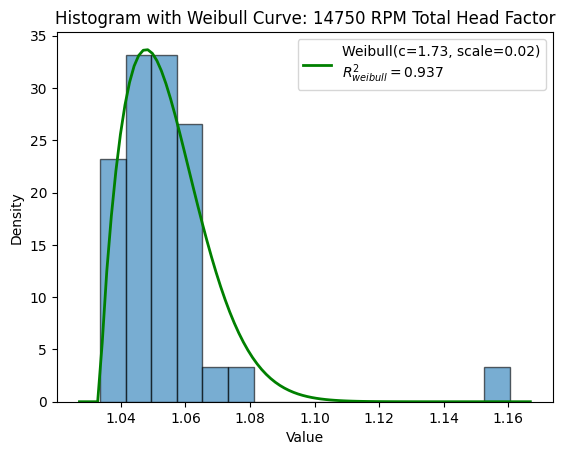

Arithmetic Mean = 1.054

Expected value (Weibull): 1.0544
Median Weibull: 1.0525
Standard Error of Mean: ±0.0055 or ±0.52% of the Expected Value
Standard Deviation : 0.0020
Standard Error of Mean Margin: 1.04% of the Expected Value
Number of samples = 38, which is 4.3% of Total Data


In [185]:
# 14750 RPM Head
# Sample data - replace this list with your actual data
data = [1.0477,1.0496,1.0579,1.0633,1.0505,1.0441,1.0652,1.0639,1.0571,1.0485,1.0335,1.0512,1.0551,1.0665,1.0552,1.0438,1.0610,1.0385,1.0571,1.0508,1.1605,1.0643,1.0405,1.0481,1.0442,1.0372,1.0430,1.0406,1.0398,1.0543,1.0467,1.0782,1.0603,1.0475,1.0575,1.0414,1.0473,1.0546]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14750 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.0035247134693596333
Suggested Number of bins: 14
Optimal Weibull parameters: shape (c) = 2.811, scale = 0.014, R² = 0.937


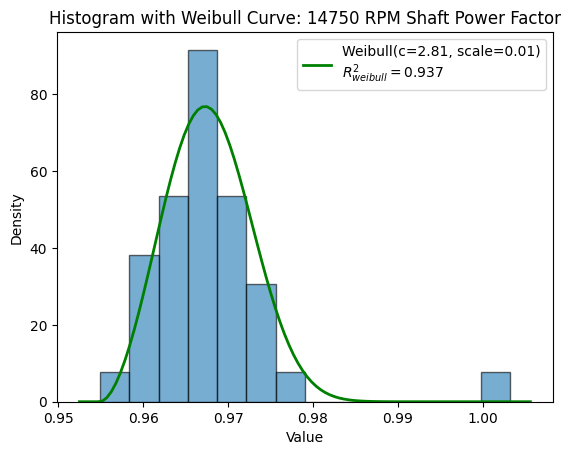

Arithmetic Mean = 0.968

Expected value (Weibull): 0.9678
Median Weibull: 0.9676
Standard Error of Mean: ±0.0022 or ±0.23% of the Expected Value
Standard Deviation : 0.0008
Standard Error of Mean Margin: 0.45% of the Expected Value
Number of samples = 38, which is 4.3% of Total Data


In [186]:
# 14750 RPM Power
# Sample data - replace this list with your actual data
data = [0.9669,0.9676,0.9697,0.9730,0.9682,0.9662,0.9707,0.9715,0.9643,0.9662,0.9606,0.9666,0.9676,0.9728,0.9702,0.9661,0.9734,0.9631,0.9700,0.9632,1.0032,0.9749,0.9644,0.9614,0.9629,0.9613,0.9687,0.9657,0.9617,0.9677,0.9604,0.9780,0.9641,0.9657,0.9682,0.9549,0.9649,0.9701]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14750 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.007208987405055147
Suggested Number of bins: 11
Optimal Weibull parameters: shape (c) = 1.246, scale = 0.021, R² = 0.639


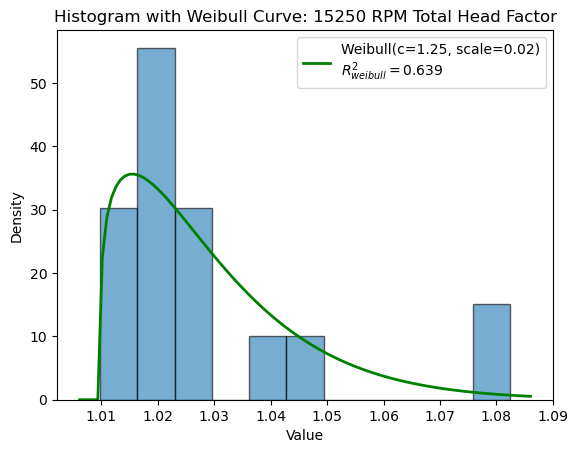

Arithmetic Mean = 1.0292

Expected value (Weibull): 1.0292
Median Weibull: 1.0253
Standard Error of Mean: ±0.0079 or ±0.77% of the Expected Value
Standard Deviation : 0.0029
Standard Error of Mean Margin: 1.53% of the Expected Value
Number of samples = 30, which is 3.4% of Total Data


In [5]:
# 15250 RPM Head
# Sample data - replace this list with your actual data
data = [1.0126,1.0246,1.0824,1.0208,1.0166,1.0475,1.0225,1.0156,1.0781,1.0220,1.0423,1.0255,1.0156,1.0202,1.0098,1.0242,1.0222,1.0291,1.0197,1.0424,1.0230,1.0230,1.0172,1.0130,1.0110,1.0209,1.0461,1.0232,1.0768,1.0288]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15250 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.4f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")


Suggested Bin width: 0.005921668225581186
Suggested Number of bins: 6
Optimal Weibull parameters: shape (c) = 1.103, scale = 0.011, R² = 0.943


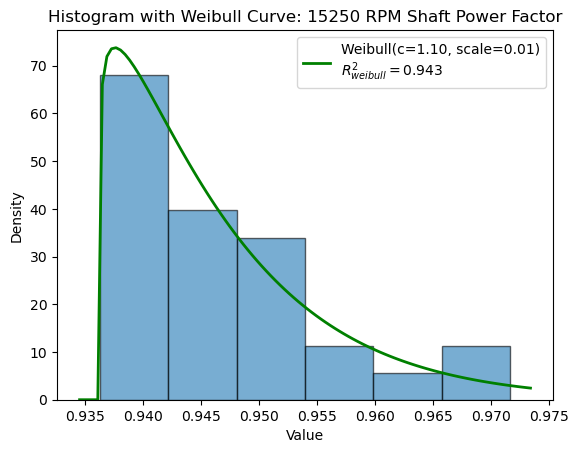

Arithmetic Mean = 0.947

Expected value (Weibull): 0.9468
Median Weibull: 0.9441
Standard Error of Mean: ±0.0048 or ±0.51% of the Expected Value
Standard Deviation : 0.0017
Standard Error of Mean Margin: 1.02% of the Expected Value
Number of samples = 30, which is 3.4% of Total Data


In [6]:
# 15250 RPM Power
# Sample data - replace this list with your actual data
data = [0.9390,0.9412,0.9659,0.9478,0.9378,0.9597,0.9461,0.9363,0.9716,0.9423,0.9561,0.9457,0.9399,0.9405,0.9420,0.9491,0.9377,0.9494,0.9469,0.9494,0.9456,0.9405,0.9392,0.9401,0.9400,0.9448,0.9497,0.9486,0.9603,0.9515]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 15250 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")

Suggested Bin width: 0.0051608913079457565
Suggested Number of bins: 13
Optimal Weibull parameters: shape (c) = 1.814, scale = 0.017, R² = 0.738


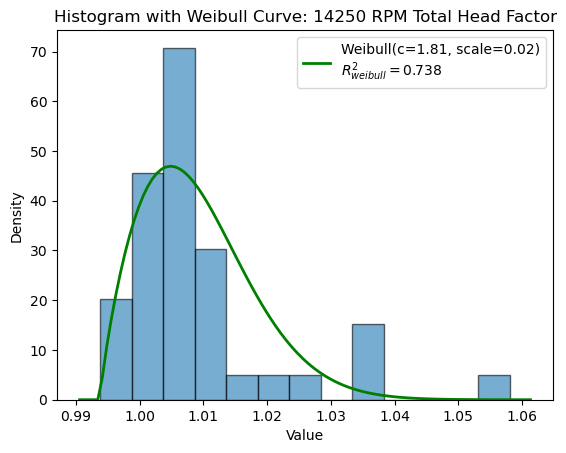

Arithmetic Mean = 1.0091

Expected value (Weibull): 1.0091
Median Weibull: 1.0079
Standard Error of Mean: ±0.0037 or ±0.37% of the Expected Value
Standard Deviation : 0.0014
Standard Error of Mean Margin: 0.74% of the Expected Value
Number of samples = 40, which is 4.5% of Total Data


In [7]:
# 14250 RPM Head
# Sample data - replace this list with your actual data
data = [1.0351,1.0002,1.0067,1.0064,1.0130,1.0091,1.0046,0.9938,1.0016,1.0029,1.0073,1.0133,1.0062,0.9983,1.0154,1.0040,1.0005,1.0035,1.0000,1.0114,1.0077,1.0041,1.0081,1.0004,0.9986,1.0369,0.9999,1.0337,1.0013,0.9957,1.0195,1.0581,1.0247,1.0088,1.0075,1.0100,1.0040,1.0040,1.0040,1.0040]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14250 RPM Total Head Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.4f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")


Suggested Bin width: 0.0029240177382128685
Suggested Number of bins: 9
Optimal Weibull parameters: shape (c) = 1.479, scale = 0.007, R² = 0.783


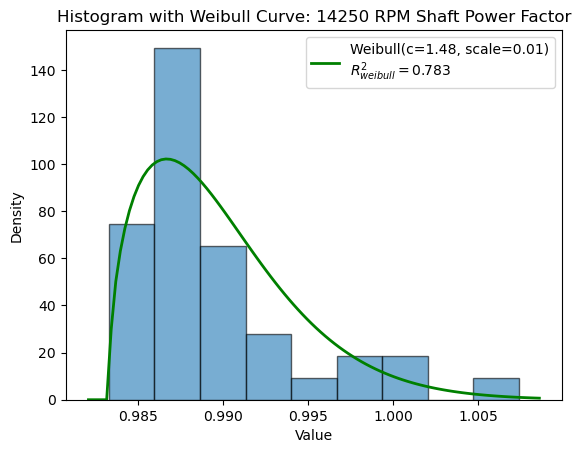

Arithmetic Mean = 0.990

Expected value (Weibull): 0.9899
Median Weibull: 0.9890
Standard Error of Mean: ±0.0019 or ±0.20% of the Expected Value
Standard Deviation : 0.0007
Standard Error of Mean Margin: 0.39% of the Expected Value
Number of samples = 40, which is 4.5% of Total Data


In [8]:
# 14250 RPM Power
# Sample data - replace this list with your actual data
data = [0.9991,0.9863,0.9907,0.9879,0.9930,0.9892,0.9865,0.9853,0.9875,0.9872,0.9876,0.9939,0.9899,0.9858,0.9999,0.9885,0.9858,0.9858,0.9845,0.9913,0.9908,0.9863,0.9881,0.9834,0.9860,0.9933,0.9864,0.9987,0.9833,0.9852,0.9961,1.0074,1.0000,0.9913,0.9884,0.9905,0.9885,0.9885,0.9885,0.9885]

# Calculate statistics for Freedman-Diaconis rule
q75, q25 = np.percentile(data, [75, 25])
iqr = q75 - q25
n = len(data)
bin_width = 2 * iqr / np.cbrt(n)  # Freedman-Diaconis bin width
data = np.array(data)
# Determine the number of bins based on the calculated bin width
num_bins = int(np.ceil((data.max() - data.min()) / bin_width))

print("Suggested Bin width:", bin_width)
print("Suggested Number of bins:", num_bins)

# Plot the histogram and capture its outputs.
# density=True normalizes the histogram so that the area under it is 1.
counts, bin_edges, patches = plt.hist(data, bins=num_bins, density=True, 
                                        alpha=0.6, edgecolor='black')

# *** Make sure to compute bin_centers from the same bin_edges ***
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation from your data.
mu = np.mean(data)
sigma = np.std(data)

# Generate x values for the smooth PDF curve.
xmin, xmax = plt.xlim()  # use the x-axis limits from the histogram
x = np.linspace(xmin, xmax, 100)

# --- Weibull Distribution Fit ---
# We fix the location parameter to the minimum of the data.
data_min = data.min()

def weibull_r2(c, bin_centers, observed, mu, data_min):
    """
    For a given Weibull shape parameter c, calculate the scale parameter so that
    the mean of the Weibull matches the sample mean mu, then compute the R² between
    the Weibull PDF (evaluated at bin_centers) and the observed histogram densities.
    """
    # Using the relation: mu = data_min + scale * Gamma(1 + 1/c)
    scale = (mu - data_min) / sps.gamma(1 + 1/c)
    predicted = weibull_min.pdf(bin_centers, c, loc=data_min, scale=scale)
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2, scale

# Search for the optimal Weibull shape parameter c that maximizes R².
c_low = 0.1
c_high = 10
tol = 1e-4  # tolerance for stopping the search

# Ternary search loop
while c_high - c_low > tol:
    c_mid1 = c_low + (c_high - c_low) / 3
    c_mid2 = c_high - (c_high - c_low) / 3
    r2_mid1, scale_mid1 = weibull_r2(c_mid1, bin_centers, counts, mu, data_min)
    r2_mid2, scale_mid2 = weibull_r2(c_mid2, bin_centers, counts, mu, data_min)
    if r2_mid1 < r2_mid2:
        c_low = c_mid1
    else:
        c_high = c_mid2

optimal_c = (c_low + c_high) / 2
optimal_r2, optimal_scale = weibull_r2(optimal_c, bin_centers, counts, mu, data_min)
print(f"Optimal Weibull parameters: shape (c) = {optimal_c:.3f}, scale = {optimal_scale:.3f}, R² = {optimal_r2:.3f}")

# Generate x values for the Weibull PDF.
x_weibull = np.linspace(xmin, xmax, 100)
weibull_pdf = weibull_min.pdf(x_weibull, optimal_c, loc=data_min, scale=optimal_scale)

# Plot the Weibull distribution curve.
plt.plot(x_weibull, weibull_pdf, 'g', linewidth=2, 
         label=f'Weibull(c={optimal_c:.2f}, scale={optimal_scale:.2f})\n$R^2_{{weibull}} = {optimal_r2:.3f}$')

# Add title, labels, and legend.
plt.title("Histogram with Weibull Curve: 14250 RPM Shaft Power Factor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Display the plot.
plt.show()

# --- Compute Expected Value and 99% Confidence Interval from the Weibull Distribution ---
# Expected value for Weibull: loc + scale * Gamma(1 + 1/c)
expected_value_weibull = data_min + optimal_scale * sps.gamma(1 + 1/optimal_c)

# Variance for Weibull: scale² * (Gamma(1+2/c) - [Gamma(1+1/c)]²)
variance_weibull = optimal_scale**2 * (sps.gamma(1 + 2/optimal_c) - sps.gamma(1 + 1/optimal_c)**2)

# Approximate standard error of the mean from the Weibull (assuming n independent samples)
std_error_weibull = np.sqrt(variance_weibull) / np.sqrt(n)

# Get the t critical value for 99% confidence (two-tailed, so 0.5% in each tail)
t_crit = t.ppf(0.995, n - 1)
ci_lower_weibull = expected_value_weibull - t_crit * std_error_weibull
ci_upper_weibull = expected_value_weibull + t_crit * std_error_weibull

# --- Compute the Weibull-based Median ---
# For a Weibull distribution, the median is given by:
#   Median = loc + scale * (ln 2)^(1/c)
median_weibull = data_min + optimal_scale * (math.log(2))**(1/optimal_c)

# Display the results.

arith_mean = np.average(data)
print(f"Arithmetic Mean = {arith_mean:.3f}")
print(f"\nExpected value (Weibull): {expected_value_weibull:.4f}")
print(f"Median Weibull: {median_weibull:.4f}")
print(f"Standard Error of Mean: ±{t_crit * std_error_weibull:.4f} "
      f"or ±{t_crit * std_error_weibull/expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Standard Deviation : {std_error_weibull:.4f}")
print(f"Standard Error of Mean Margin: {t_crit * std_error_weibull * 2 /expected_value_weibull*100:.2f}% of the Expected Value")
print(f"Number of samples = {len(data)}, which is {len(data)/880*100:.1f}% of Total Data")